Based on the following links to create this notebook:

https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy#scrollTo=bhsj7BTPHepg

https://colab.research.google.com/drive/1tug_bpg8RwrFOI8C6Ed-zo0OgD3yfnWy


To run Gym, you have to install prerequisites like xvbf,opengl & other python-dev packages using the following codes.

In [ ]:
!pip install gym 
!apt-get install python-opengl ffmpeg -y 
!apt install xvfb -y 
!pip install pyvirtualdisplay  
!pip install piglet 
!pip install gym[box2d] 
!pip install tensorflow 


In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [5]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

# My Code

In [6]:
class defaultActions:
    def __init__(self):
        self.a1 = [0,0] #engiens off
        self.a2 = [0.5,0]# main slow
        self.a2 = [0.75,0]# main meduim
        self.a4 = [1,0] # main storng
        self.a4 = [0,-0.5] # left slow
        self.a4 = [0,-0.5] # left slow
        self.main = [[0 , "Main off"],
                     [0.5 ,"Main slow"],
                     [0.75 , "Main meduim"],
                     [1    , "Main strong"]
                    ]
        self.left_right = [
                        [0, "Left Right off"],
                        [-0.5 , "Left slow"],
                        [-0.75  , "Left meduim"],
                        [-0.1 , "Left strong"],
                        
                        [0.5 , "Right slow"],
                        [0.75  , "Right meduim"],
                        [0.1 , "Right strong"],
                        ]
        self.all_actions = {}
        i = 0  
        for main_eng in self.main:
            for sec_eng in self.left_right:
#                 print (f"a{i},act:[{main_eng[0]},{sec_eng[0]},{main_eng[1]} {sec_eng[1]}]")
                self.all_actions[i] = [[main_eng[0],sec_eng[0]] , f"{main_eng[1]}, {sec_eng[1]}"]
                i+=1
        
    def get_full_action(self,id):
        return self.all_actions[id]

    def get_action(self,id):
        return self.all_actions[id][0]

    def get_description(self,id):
        return self.all_actions[id][1]
    def get_action_count(self):
        return len(self.all_actions)
actions = defaultActions()
actions.get_action_count()

28

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

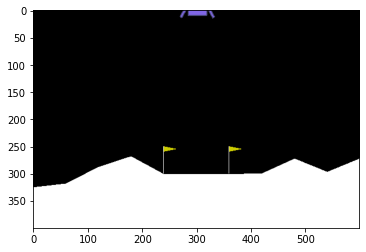

In [8]:
# Box2d Environment
env = gym.make('LunarLanderContinuous-v2')
env.reset()
plt.imshow(env.render('rgb_array'))


In [9]:
state_size = env.observation_space
print("state size is:", state_size)
a = env.action_space
print("action size=",a) 
state = env.reset()
print(state)   

state size is: Box(-inf, inf, (8,), float32)
action size= Box(-1.0, 1.0, (2,), float32)
[-0.00214519  1.4149768  -0.21730165  0.18030304  0.00249254  0.04922206
  0.          0.        ]


# Action Space
            #is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)

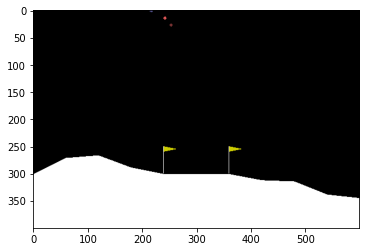

0


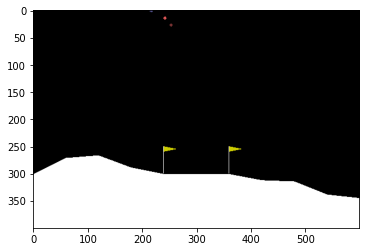

In [10]:
env = wrap_env(env)
done = False
iter = 0
print(done)
state = env.reset()

action = 1
TotalReward = 0;
while not done and iter < 30 :
  iter +=1
#   action = env.action_space.sample()
  action =  random.choice(actions.all_actions)
  print("action is:",action)
  action = action[0]
  observation, reward, done, _ = env.step(action)
  #print("state is:", observation)

  #if you want to see results on real-time 'open' the following 4 lines
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
print(TotalReward)

In [11]:
env.close()
show_video()

In [12]:
print(iter)

30


In [13]:
#Draw random samples from a normal (Gaussian) distribution.
mu, sigma = 0, 0.05 # mean and standard deviation
s = np.random.normal(mu, sigma, 1)
print(s)

[-0.0006669]
